# Unsupervised K-Means Clustering Analysis

In [26]:
import pandas as pd
import torch
import numpy as np
from sklearn.cluster import KMeans 
import random
import km_model as km
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

NUM_SEQUENCES_PER_BATCH = 1024

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [8]:
# Load the pre-trained model
embedder = km.Embedder('all-MiniLM-L6-v2', device=device)

In [9]:
#load the data, tuples
similar_song_lyrics = pd.read_csv("data/kat_data_similar_songs.csv") 
similar_song_lyrics.head()

,title,artist,song,similar_lyrics,similar_track,similar_artist
0,Cuéntale,Ivy Queen,Cuéntale by Ivy Queen,4 ContributorsDile LyricsQuien te va a querer ...,Dile,Ivy Queen
1,Cuéntale,Ivy Queen,Cuéntale by Ivy Queen,3 ContributorsCansada LyricsWelcome to the dra...,Cansada,Ivy Queen
2,Cuéntale,Ivy Queen,Cuéntale by Ivy Queen,11 ContributorsTranslationsEnglishDeutschElla ...,Ella Me Levantó,Daddy Yankee
3,Cuéntale,Ivy Queen,Cuéntale by Ivy Queen,"12 ContributorsDale Don Dale Lyrics[Letra de ""...",Dale Don Dale,Don Omar
4,Cuéntale,Ivy Queen,Cuéntale by Ivy Queen,"8 ContributorsSexy Robótica Lyrics[Letra de ""S...",Sexy Robotica,Don Omar


In [10]:
#Grab the lyrics and the corresponding similar song title
lyrics, similar_song_title = similar_song_lyrics["similar_lyrics"].tolist(), similar_song_lyrics["song"].tolist()
processed_lyrics = []
for lyric in lyrics:
    processed_lyrics.append(km.preprocess_sentence(lyric))

In [11]:
# Grab the embeddings for the lyrics
embeddings = embedder(processed_lyrics, batch_size=NUM_SEQUENCES_PER_BATCH).cpu().numpy()

## Evaluation of the Model with 10 Clusters: Similarity or Dissimilarity to Fire Burning by Sean Kingstonm

In [16]:
# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(embeddings)

# Initialize and fit the KMeans model
kmeans = KMeans(n_clusters=10, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans.fit(X_scaled)

# Retrieve the clustering results
labels = kmeans.labels_
centers = kmeans.cluster_centers_
#print("Cluster Labels:", labels)
#print("Cluster Centers (scaled):", centers)

# Calculate silhouette score
score = silhouette_score(X_scaled, labels)
print("Silhouette Score:", score)

Silhouette Score: 0.021556487


Labels that are not similar to: Fire Burning by Sean Kingston <br>
* 252 -  'Honey' by Kehlani
* 11 - 505 by Arctic Monkeys
* 13 - 8TEEN by Khalid
* 21 - American Requiem by Beyonce

Labels somewhat similar to : Fire Burning by Sean Kingston <br>
* 336 - Low  by Flo Rida
* 431 - Promiscuous
* 294 - Just Dance

In [20]:
potential_indices = [336, 431, 252]
name_indices = ["Low by Flo Rida", "Promiscuous by Nelly Furtado", "Honey by Kehlani"]

clusters = km.get_assigned_clusters(potential_indices, labels)

for i, cluster in enumerate(clusters):
    print(f"Song: {name_indices[i]}, Cluster: {cluster}")

Song: Low by Flo Rida, Cluster: 6
Song: Promiscuous by Nelly Furtado, Cluster: 6
Song: Honey by Kehlani, Cluster: 4


## Evaluation of the Model with 2 Clusters: Separation of English vs Spanish Songs

In [21]:
# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(embeddings)

# Initialize and fit the KMeans model
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans.fit(X_scaled)

# Retrieve the clustering results
labels = kmeans.labels_
centers = kmeans.cluster_centers_
#print("Cluster Labels:", labels)
#print("Cluster Centers (scaled):", centers)

# Calculate silhouette score
score = silhouette_score(X_scaled, labels)
print("Silhouette Score:", score)

Silhouette Score: 0.16780578


In [23]:
english_songs = km.select_random_samples_by_cluster(similar_song_lyrics, labels, 0, 5)
spanish_songs = km.select_random_samples_by_cluster(similar_song_lyrics, labels, 1, 5)

print("English Songs:")
for song in english_songs:
    print(song)
print("\nSpanish Songs:")
for song in spanish_songs:
    print(song)

English Songs:
Estoy Enamorado by Omega
Body Aint Me by Pink Sweat$
Easier by 5 Seconds of Summer
Lamb's Wool by Foster The People
HONEY (ARE U COMING?) by Måneskin

Spanish Songs:
Yo Voy (feat. Daddy Yankee) by Zion & Lennox
Mayor Que Yo by Wisin & Yandel
777-666 by Matuê
A Tu Merced by Bad Bunny
Doncella by Zion & Lennox


## Principal Component Analysis (PCA)

We decided to implement a Dimensionality Reduction technique with the goal to improve the clustering step. Unfortunately, we needed around $\sim 250$ dimensions from the 384 embedding size of the encoder to recapitulate 95% of the variance. Therefore, we decided to not apply it to our clustering process. 

In [33]:
from sklearn.decomposition import PCA

pca = PCA(n_components=250)
X_reduced = pca.fit_transform(X_scaled)

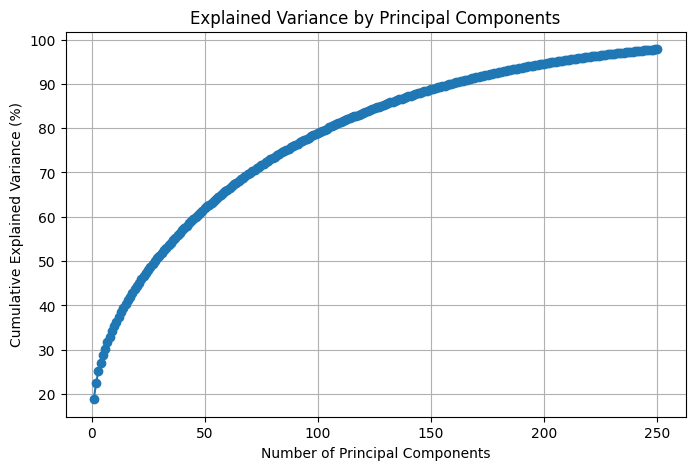

In [34]:
# Compute the cumulative variance explained
cumulative_variance = np.cumsum(pca.explained_variance_ratio_) * 100

plt.figure(figsize=(8, 5))
plt.plot(range(1, 250 + 1), cumulative_variance, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance (%)")
plt.title("Explained Variance by Principal Components")
plt.grid(True)
plt.show()